<a href="https://colab.research.google.com/github/muhdlaziem/automated-hazard-detection/blob/main/air_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/muhdlaziem/automated-hazard-detection.git
%cd /content/automated-hazard-detection/air-quality

Cloning into 'automated-hazard-detection'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 7 (delta 0), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.
/content/automated-hazard-detection/air-quality


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import regularizers
from keras.optimizers import Adam
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint

1.	**station_id:** Unique identifier of the PM 2.5 monitors stationed across US
2.	**stime:** Time and date of sample recorded
3.	**air_data_value:** EPA air data PM2.5 readings
4.	**RH:** relative humidity from HRRR
5.	**UGRD, VGRD:** Wind speed vectors from HRRR
6.	**HPBL:** Height of Planetary Boundary Layer from HRRR
7.	**TMP:** Temperature recorded from HRRR
8.	**goes_measurement:** AOD reading from GOES R


In [ ]:
np.random.seed(3)
df = pd.read_csv("PM2.5_dataset.csv")
df.head()

,Unnamed: 0,station_id,stime,air_data_value,RH,UGRD,VGRD,HPBL,TMP,goes_measurement
0,0,06-011-0007,2019-01-02 20:00:00,17.0,31.600000,-2.106623,-1.797583,256.61905,282.8188,-0.005922
1,1,06-019-0500,2019-01-02 20:00:00,13.0,62.200000,1.205877,1.764917,337.49405,281.6313,0.087090
2,2,06-061-0003,2019-01-02 20:00:00,21.0,61.500000,1.518377,1.014917,270.61905,280.1313,0.094333
3,3,06-073-1201,2019-01-02 20:00:00,6.0,15.400001,2.080877,-1.610083,1009.30660,288.1938,-0.024185
4,4,06-079-2004,2019-01-02 20:00:00,7.0,50.700000,2.393377,-1.172583,460.43155,285.1938,-0.014013


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31570 entries, 0 to 31569
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        31570 non-null  int64  
 1   station_id        31570 non-null  object 
 2   stime             31570 non-null  object 
 3   air_data_value    31570 non-null  float64
 4   RH                31570 non-null  float64
 5   UGRD              31570 non-null  float64
 6   VGRD              31570 non-null  float64
 7   HPBL              31570 non-null  float64
 8   TMP               31570 non-null  float64
 9   goes_measurement  31570 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.4+ MB


In [ ]:
df.dtypes

Unnamed: 0            int64
station_id           object
stime                object
air_data_value      float64
RH                  float64
UGRD                float64
VGRD                float64
HPBL                float64
TMP                 float64
goes_measurement    float64
dtype: object

In [ ]:
# drop first col
# df = df[df.columns[3:]]
# df.head()

In [ ]:
df['stime'] = pd.to_datetime(df['stime'], format='%Y-%m-%d %H:%M:%S')

Wind direction formula: <br>
Direction = 57.29578 * (arctangent(UGRD, VGRD)) + 180

Wind speed formula: <br>
Speed = sqrt(UGRD \* UGRD + VGRD * VGRD)

In [ ]:
# calc wind speed and direction
win_speed = np.sqrt(df['UGRD']**2 + df['VGRD']**2)
win_dir = 57.29578 * np.arctan2(df['UGRD'],df['VGRD']) + 180
print(win_dir.shape, win_speed.shape)
# df.head()

(31570,) (31570,)


In [ ]:
df["win_dir"] = win_dir
df["win_speed"] = win_speed
df.head()

,Unnamed: 0,station_id,stime,air_data_value,RH,UGRD,VGRD,HPBL,TMP,goes_measurement,win_dir,win_speed
0,0,06-011-0007,2019-01-02 20:00:00,17.0,31.600000,-2.106623,-1.797583,256.61905,282.8188,-0.005922,49.525850,2.769325
1,1,06-019-0500,2019-01-02 20:00:00,13.0,62.200000,1.205877,1.764917,337.49405,281.6313,0.087090,214.342787,2.137539
2,2,06-061-0003,2019-01-02 20:00:00,21.0,61.500000,1.518377,1.014917,270.61905,280.1313,0.094333,236.240346,1.826343
3,3,06-073-1201,2019-01-02 20:00:00,6.0,15.400001,2.080877,-1.610083,1009.30660,288.1938,-0.024185,307.730979,2.631049
4,4,06-079-2004,2019-01-02 20:00:00,7.0,50.700000,2.393377,-1.172583,460.43155,285.1938,-0.014013,296.101529,2.665184


In [ ]:
df.isnull().values.any()

False

## Exploratory Data Analysis 

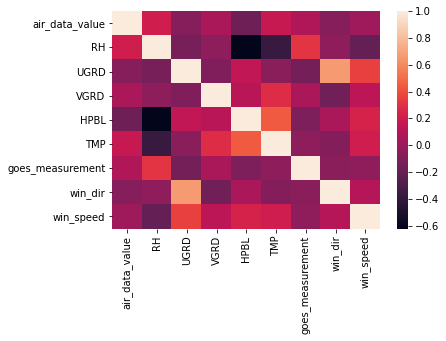

In [ ]:
sns.heatmap(df[df.columns[3:]].corr())
plt.show()

In [ ]:
df['air_data_value']

0        17.0
1        13.0
2        21.0
3         6.0
4         7.0
         ... 
31565     6.3
31566     6.4
31567     8.5
31568     8.1
31569     2.1
Name: air_data_value, Length: 31570, dtype: float64

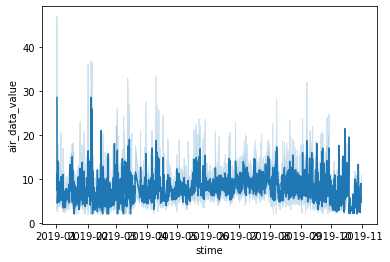

In [ ]:
sns.lineplot(data = df, x = 'stime', y = 'air_data_value')
plt.show()

## Preprocess

In [ ]:
# drop first col
df = df[df.columns[3:]]
df.head()

,air_data_value,RH,UGRD,VGRD,HPBL,TMP,goes_measurement,win_dir,win_speed
0,17.0,31.600000,-2.106623,-1.797583,256.61905,282.8188,-0.005922,49.525850,2.769325
1,13.0,62.200000,1.205877,1.764917,337.49405,281.6313,0.087090,214.342787,2.137539
2,21.0,61.500000,1.518377,1.014917,270.61905,280.1313,0.094333,236.240346,1.826343
3,6.0,15.400001,2.080877,-1.610083,1009.30660,288.1938,-0.024185,307.730979,2.631049
4,7.0,50.700000,2.393377,-1.172583,460.43155,285.1938,-0.014013,296.101529,2.665184


In [ ]:
# load data and labels in array
narray=np.array(df)

#split features and labels
target=np.array(narray[:,0])
narray=narray[:,1:]

print(target.shape, narray.shape)

(31570,) (31570, 8)


In [ ]:
# normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
narray = scaler.fit_transform(narray)

In [ ]:
# convert an array of values into a dataset matrix
# def create_dataset(dataset,target, look_back=1):
#     dataX, dataY = [], []
#     for i in range(len(df)):
#         a = dataset[(i-look_back+1):i+1, :]
#         dataX.append(a)
#         dataY.append(target[i])
#     return np.array(dataX), np.array(dataY)

In [ ]:
# look_back = 4
# X,Y= create_dataset(narray,target, look_back)

In [ ]:
print(narray.shape, target.shape)

(31570, 8) (31570,)


## Model

In [ ]:
# split into train-test
trainX, testX, trainY, testY = train_test_split(narray, target, test_size=0.20, random_state=777)
# split data into train-validation set
X_train, X_val, y_train, y_val = train_test_split(trainX, trainY, test_size=0.20, random_state=777)

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(Dense(64, input_dim=8, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='relu'))
# model.add(Dense(30))
# model.add(Dense(30,kernel_regularizer=regularizers.l2(0.01)))
# model.add(Dense(20))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
# optimizer = Adam(lr=0.0001)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 68        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
checkpoint_path='/content/drive/My Drive/model.h5'
keras_callbacks   = [
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

In [ ]:
history=model.fit(X_train, y_train, epochs=1000, batch_size=16, verbose=2, validation_data=(X_val,y_val), shuffle=True, callbacks=keras_callbacks)

Epoch 1/1000
1263/1263 - 4s - loss: 34.4694 - val_loss: 29.9811
Epoch 2/1000
1263/1263 - 3s - loss: 30.7176 - val_loss: 28.3887
Epoch 3/1000
1263/1263 - 3s - loss: 30.0729 - val_loss: 27.7264
Epoch 4/1000
1263/1263 - 3s - loss: 29.4551 - val_loss: 27.5953
Epoch 5/1000
1263/1263 - 3s - loss: 28.2918 - val_loss: 26.3244
Epoch 6/1000
1263/1263 - 3s - loss: 27.4214 - val_loss: 24.9679
Epoch 7/1000
1263/1263 - 3s - loss: 26.7779 - val_loss: 24.7240
Epoch 8/1000
1263/1263 - 3s - loss: 26.3121 - val_loss: 27.9432
Epoch 9/1000
1263/1263 - 3s - loss: 26.3771 - val_loss: 23.7644
Epoch 10/1000
1263/1263 - 3s - loss: 25.8154 - val_loss: 24.5552
Epoch 11/1000
1263/1263 - 3s - loss: 25.9859 - val_loss: 24.1468
Epoch 12/1000
1263/1263 - 3s - loss: 25.5750 - val_loss: 23.9967
Epoch 13/1000
1263/1263 - 3s - loss: 25.3560 - val_loss: 24.3561
Epoch 14/1000
1263/1263 - 3s - loss: 25.2474 - val_loss: 23.5665
Epoch 15/1000
1263/1263 - 3s - loss: 25.2166 - val_loss: 23.7538
Epoch 16/1000
1263/1263 - 3s - los

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

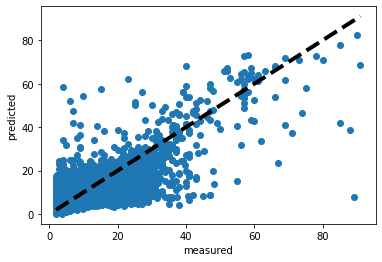

In [ ]:
fig, ax = plt.subplots()
ax.scatter(trainY,trainPredict)
ax.plot([trainY.min(), trainY.max()], [trainY.min(), trainY.max()], 'k--', lw=4)
ax.set_xlabel('measured')
ax.set_ylabel('predicted')
plt.show()

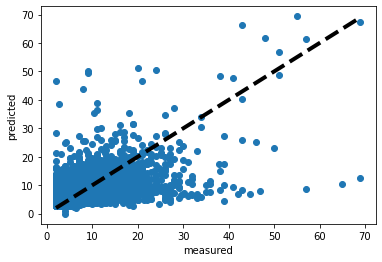

In [ ]:
fig, ax = plt.subplots()
ax.scatter(testY,testPredict)
ax.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'k--', lw=4)
ax.set_xlabel('measured')
ax.set_ylabel('predicted')
plt.show()

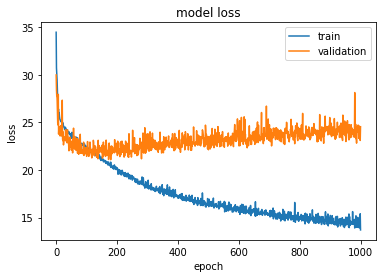

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
np.expand_dims(testX[0], axis=0).shape

(1, 8)

In [ ]:
model.predict(np.expand_dims(testX[0], axis=0))[0][0]

25.7387